# Biclustering via Sparse Singular Value Decomposition

### Jingxuan Zhang, Jae Hyun Lee

## Abstract

Biclustering via Sparse Singular Value Decomposition(SSVD) is initially proposed by Lee et al.(2010). The main idea is that SSVD can be used as one of Biclustering methods in that it can identify latent association in columns and row simultaneously in the course of singular value decomposition with sparsity limitation. Biclustering is a collection of unsupervised learning methods which detects checkboard structured association between rows and columns in data and is often used for high dimensional data. In this paper, we translated Lee et al's publically available R and matlab code about SSVD into python code and optimized their algorithms by `Numba` with parallelization option to make the speed of execution faster. After optimization, this algorithm was applied to both simulated data and real data. The simulated data is the same data described in Lee et al's paper and real data are lung cancer data which was used in Lee's paper and breast cancer data from outside. At last, the performance of optimized SSVD was compared with existing Biclustering and decomposition algorithm in their time and accuracy. 

#### KEY WORDS: Biclustering, high dimensional data, singular value decomposition, sparsity, and optimazation

## Background

The paper Biclustering via Sparse Singular Value Decomposition' newly propose SSVD as a Biclustering method. Biclustering is a collection of unsupervised learning methods which play a important role in exploratory data analysis, especially in high dimensional data. Biclustering identifies association between rows and columns in data simultaneously and produce latent checkboard structured in data which is more interpretable than raw data. This unsupervised method is widely used for High dimensional low sample size(HDLSS) data which cannot use traditional statistical methods that requires relatively large sample size. 

Recently, HDLSS is a common feature in medical data such as microarray gene expression and in text mining/categorization. SSVD can be applied to deal with these problems as one of Biclustering methods. For application in text mining, Biclustering can be used to reveal association between documents and word clusters. In this paper, in the context of microarray gene analysis, Biclustering detect association between disease and certain gene expression in a lung cancer microarray dataset.

According to Lee, SSVD naturally implement Biclustering in the course of low rank approximation using singluar value decomposition with sparsity-inducing penalties. Non-zero entries in both sides' singular vectors are clustered and this makes SSVD be able to be used as Biclustering method. By detecting non-zero clusters in data, it is possible to find association between certain rows and columns. However, regression with adaptive lasso penalty which does not have closed form of solution is used in decomposing sparsed matrix. Therefore, it requires iterative steps to find optimal value of penalty parameter in regression and this process takes most of time used in SSVD. Consequently, optimazation of SSVD in this paper focus on reducing computation cost and time of this iterative step. 

Therefore, in this project, this SSVD algorithm was used for finding latent checkboard structure under lung cancer data from the paper and breast cancer data from outside source. For future application, this algorithm is expected to be used in most of gene-micro array expression data which is HDLSS data.

## Descripition of algorithm

As decribed above, Biclustering methods are used to identify distinctive patterns in a large data matrices that are significantly associated between columns or rows. To realize this function, we used a new algorithm proposed by Lee et al. called SSVD aiming to approximate of X in a low-rank version while containing numbers of zeros terms. This means that the SVD result of $u_k$ and $v_k$ could contain numbers of zeros, which is called sparcity. Thus, the final goal of this algorithm is finding best low rank approximation with adaptive lasso penalty as lasso regression.


The objective function to minimize is:
$∥X − suv^T ∥^2_F + \lambda_u P_1(su) + \lambda_v P_2(sv)$
where $P_1(su)$ and $P_2(sv)$ are sparsity-inducing penalty terms whose forms will be given later, and $\lambda_u$ and $\lambda_v$ are two nonnegative penalty parameters.

Applying the knowledege of lasso regression, for a fixed $u$, $min ∥X − suv^T ∥^2_F + \lambda_u P_1(su) + \lambda_v P_2(sv) = min ∥X−u\tilde{v}^T ∥^2_F + \lambda_v P_2(\tilde{v}) = min ∥Y−(I_d ⊗u)\tilde{v}∥^2 +\lambda_v P_2(\tilde{v})$ 
where $\tilde{v} = sv$, $Y = (x^T_1 ,...,x^T_d )^T \in R^{n\times d}$ with $x_j$ being the jth column of X, and ⊗ being the Kronecker product.

We set up the penalty parameters with weight vectors, then $P_2(sv) = s \sum_{i=1}^n w_{2,j} |v_j|$.

Similarly, for a fixed $v$, we can get a symmetric result.

#### An Iterative Algorithm

With the adaptive lasso penalty, the minimizing objective for SSVD can be rewritten as
$min ∥X − suv^T ∥^2_F + \lambda_u P_1(su) + \lambda_v P_2(sv) = min ∥X−suv^T ∥_F +s \lambda_u \sum_{i=1}^n w_{1,i}|u_i|+s\lambda_v \sum_{j=1}^d w_{2,j}|v_j|$.

For fixed $u$, the alternative minimizing objective can become $min ∥X−u\tilde{v}T∥^2_F + \lambda_v \sum_{j=1}^d w_{2,j}|\tilde{v}_j|$ 

So the alternating for minimization between $u$ and $v$ can be iterated until convergence. After convergence, simply set $s = u^T Xv$ and the SSVD layer is given by $suv^T$.

#### Penalty Parameter Selection

The degrees of sparsity of u and v are closely related to the two penalty parameters $\lambda_u$ and $\lambda_v$. It is also proved that the degree of sparsity of $u$ or $v$ is a step function of the penalty parameter $\lambda_u$ and $\lambda_v$ respectively, selecting the parameters is equivalent to selecting the degrees of sparsity.

For the penalized regression with fixed $u$, define
$BIC(\lambda_v)= \frac{∥Y − \hat{Y}∥^2}{nd \cdot \hat{\sigma}^2} + \frac{\log(nd)}{nd} \hat{df}(\lambda_v)$ 
where $df(\lambda_v)$ is the degree of freedom of $v$ and $\sigma^2$ is the OLS estimate of the error variance from the model for fixed $u$

#### Pipeline for SSVD Algorithm

Step 1. Apply the standard SVD to a data matrix $X$. Let $\{s_{old}, v_{old}, u_{old}\}$ denote the first SVD triplet.

Step 2. Update the previous result:

(a) Set $\tilde{v_j} =sign\{(X^T u_{old})_j\}(|(X^T u_{old} )_j | − \lambda_v w_{2,j} / 2)_+$, $j = 1,...,d$, where $\lambda_v$ is the minimizer of $BIC(\lambda_v)$ defined above. Let $\tilde{v} = (\tilde{v}_1,...,\tilde{v}_d)^T$, $s = ∥\tilde{v}∥$, and $v_{new} = \tilde{v} / s$.

(b) Set $\tilde{u_i} =sign\{(X^T v_{new})_i\} (|(X^T v_{new} )_i | − \lambda_u w_{1,i} / 2)_+$, $i = 1,...,d$, where $\lambda_u$ is the minimizer of $BIC(\lambda_u)$ defined above. Let $\tilde{u} = (\tilde{u}_1,...,\tilde{u}_d)^T$, $s = ∥\tilde{u}∥$, and $u_{new} = \tilde{u} / s$.

(c) Set $u_{old} = u_{new}$ and repeat Steps 2(a) and 2(b) until convergence.

Step 3. Set $u = u_{new}$, $v = v_{new}$, $s = u^T_{new} X v_{new}$ at convergence.

#### A Penalized Sum-of-Squares Criterion
According to the preliminary knowledge, the first SVD layer $s_1$, $u_1$, $v^T_1$, can form the best rank-one matrix approximation of X under the Frobenius norm, i.e., $(s_1, u_1, v_1) = argmin_{\{s, u, v\}} ∥X − suv^T ∥^2_F $
where $s$ is a positive scalar, $u$ is a unit n-vector, and $v$ is a unit d-vector. 

## Description of optimazation for algorithm

Optimazation and profiling of SSVD from Lee's publically available code was conducted using lung cancer data which was also used in Lee's paper. Lung cancer data has a lot of columns and small number of observations(56 $\times$ 12625) which indicates that this data is HDLSS data.

In [1]:
%load_ext line_profiler

In [2]:
#package import
import pandas as pd
import numpy as np
import timeit
import time
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from numba import jit
from numba import int32, int64, float32, float64, boolean
from numba import njit, prange

In [3]:
#data import
X = np.loadtxt('data/lung_cancer.txt').T
X.shape

(56, 12625)

#### Vanilla SSVD - unoptimized

In [4]:
#Threshold function
def thresh(X,ttyp, plambda):
    #ttyp: threshhold type
    #plambda: penalty lambda
    a = 3.7    
    if ttyp==1:
        tmp= np.sign(X)*(np.abs(X)>=plambda)
        y = tmp*np.abs(X)-plambda
    elif ttyp==2:
        y = X*(np.abs(X)>paralambda)
    return y

#ssvd fucntion - unoptimized
def ssvd_vanilla(X,param=None):
    n, d = X.shape
    ttypu = 1;ttypv = 1 #threshold type for u,v
    gamu = 0;gamv = 0   #nonnegative parameter 
    u, s, v = np.linalg.svd(X)
    u0 = u[:,0]
    v = v.T; v0 = v[:,0]
    tol = 10**-4
    niter = 20
    ud = 1
    vd = 1
    iters = 0
    SST = np.sum(X**2)
    while (ud > tol or vd > tol):
        iters = iters + 1
        
        #Updating v
        zv = np.matmul(X.T,u0)
        wv = abs(zv)**gamv     #data driven weight
        sigsq = (SST - np.sum(zv**2))/(n*d-d)
        tv = np.sort(np.append(abs(zv**wv),0))
        pv = sum(tv>0)
        Bv = np.ones((d+1,1))*np.Inf
        for i in range(0,pv):
            lvc = tv[d-i]
            para = {'ttyp': ttypv, 'plambda': lvc/wv[wv!=0]}
            temp2 = thresh(zv[wv!=0],para['ttyp'],para['plambda'])
            vc = temp2
            Bv[i] = sum(sum((X - u0[:,np.newaxis]*vc[:,np.newaxis].T)**2)/sigsq + i*np.log(n*d))
        Iv = np.argmin(Bv)+1
        temp = np.sort(np.append(abs(zv* wv),0))
        lv = temp[d-Iv-1]
        para['plambda'] = np.multiply(lv, wv[wv!=0])
        temp2 = thresh(zv[wv!=0],para['ttyp'],para['plambda'])
        v1 = temp2
        v1 = v1/np.sqrt(sum(v1**2)) #v_new

        #Updating u
        zu = np.matmul(X, v1)
        wu = abs(zu)**gamu
        sigsq = (SST - sum(zu**2))/(n*d-n)
        tu = np.sort(np.append(abs(zu**wu),0))
        pu = sum(tu>0)
        Bu = np.ones((n+1,1))*np.Inf
        for i in range(0,pu):
            luc = tu[n-i]
            para = {'ttyp': ttypu, 'plambda': luc/wu[wu!=0]}
            temp2 = thresh(zu[wu!=0],para['ttyp'],para['plambda'])
            uc = temp2
            Bu[i] = sum(sum((X - uc[:,np.newaxis]*v1[:,np.newaxis].T)**2)/sigsq + i*np.log(n*d))
        Iu = np.argmin(Bu)+1
        temp = np.sort(np.append(abs(zu*wu),0))
        lu = temp[n-Iv-1]
        para['plambda'] = lu/wu[wu!=0]
        temp2 = thresh(zu[wu!=0],para['ttyp'],para['plambda'])
        u1 = temp2
        u1 = u1/np.sqrt(sum(u1**2)) #u_new

        ud = np.sqrt(np.sum((u0-u1)**2))
        vd = np.sqrt(np.sum((v0-v1)**2))
        if iters > niter:
            print('Fail to converge! Increase the niter!')
            break
        u0 = u1
        v0 = v1
    u = u1
    v = v1
    return u,s[0],v,iters

In [28]:
%%time
u,s,v,iters = ssvd_vanilla(X)

CPU times: user 9min 27s, sys: 57.5 s, total: 10min 25s
Wall time: 7min 57s


In [29]:
%lprun -s -f ssvd_vanilla -T data/ssvd_results.txt ssvd_vanilla(X)
%cat data/ssvd_results.txt


*** Profile printout saved to text file 'data/ssvd_results.txt'. 
Timer unit: 1e-06 s

Total time: 472.926 s
File: <ipython-input-4-be84f0e0a4c8>
Function: ssvd_vanilla at line 14

Line #      Hits         Time  Per Hit   % Time  Line Contents
    14                                           def ssvd_vanilla(X,param=None):
    15         1          6.0      6.0      0.0      n, d = X.shape
    16         1          3.0      3.0      0.0      ttypu = 1;ttypv = 1 #threshold type for u,v
    17         1          2.0      2.0      0.0      gamu = 0;gamv = 0   #nonnegative parameter 
    18         1   37470685.0 37470685.0      7.9      u, s, v = np.linalg.svd(X)
    19         1         11.0     11.0      0.0      u0 = u[:,0]
    20         1          5.0      5.0      0.0      v = v.T; v0 = v[:,0]
    21         1          1.0      1.0      0.0      tol = 10**-4
    22         1          1.0      1.0      0.0      niter = 20
    23         1          2.0      2.0      0.0      ud = 1
 

At first, we were able to find that unoptimized `ssvd_vanilla` function for lung cancer data takes about 10 minutes for CPU times and about 8 minutes for Wall time. It may take so long time to execute function if we consider the size of data. To reduce running time and optimize it with `Numba` pacakage, we decided to profile this function by line. When we investigated the result of profiling, we could find that line 18, line 37~42, and line 58~63 consumed most of running time. These parts are related with singular value decomposition of matrix and updating singular vectors u and v. Thus, we decided to seperate them from original function and optimze them individually. First, we found that updating u and v includes iterative loop and we decided to optimize them with `@njit` and `prange` function which makes iteration even faster. Second, we optimized `np.linalg.svd` function with `@jit` decorator and this process had significant effect. Lastly, we replaced `while` function in main `ssvd_vanilla` function with prange so that running time for iterative steps could be reduced. 

#### Optimized SSVD

In [5]:
@njit(parallel=True)
def updateU(Bu,idx,n,d,pu,tu,wu,z,v1,X,sigsq):
    for i in prange(0,pu):
        luc = tu[idx[i]]
        plambda = luc/wu[wu!=0]
        tmp= np.sign(z[wu!=0])*(np.abs(z[wu!=0])>=plambda)  
        uc = tmp*(np.abs(z[wu!=0])-plambda)
        Bu[i] = np.sum((X - np.outer(uc,v1))**2)/sigsq + (i+1)*np.log(n*d) #this works best
        
    return Bu

In [6]:
@njit(parallel=True)
def updateV(Bv,idx,n,d,pv,tv,wv,z,u0,X,sigsq):
    for i in prange(0,pv):
        lvc = tv[idx[i]]
        plambda = lvc/wv[wv!=0]
        tmp= np.sign(z[wv!=0])*(np.abs(z[wv!=0])>=plambda)                         
        vc = tmp*(np.abs(z[wv!=0])-plambda)
        Bv[i] = np.sum((X - np.outer(u0,vc))**2)/sigsq + (i+1)*np.log(n*d) #this works best
        
    return Bv

In [7]:
@jit(nopython = True)
def svd(X):
    return np.linalg.svd(X)

In [8]:
@njit(parallel = True)
def ssvd_opt(X, niter = 100):
    n, d = X.shape
    ttypu = 1; ttypv = 1
    gamu = 0; gamv = 0
    u, s, v = svd(X)
    v = v.T
    u0 = u[:,0]; v0 = v[:,0]
    tol = 1e-4
    ud = 1;vd = 1
    SST = np.sum(X**2)
    for iters in prange(niter):
        zv = X.T@u0
        wv = np.abs(zv)**gamv
        sigsq = (SST - np.sum(zv**2))/(n*d-d)
        tv = np.sort(np.append(np.abs(zv**wv),0))
        pv = np.sum(tv>0)
        Bv = np.ones(d+1)*np.Inf
        idx = np.arange(d-1,-1,-1)
        Bv = updateV(Bv,idx,n,d,pv,tv,wv,zv,u0,X,sigsq)
        Iv = np.argmin(Bv) + 1
        lv = tv[d-Iv]
        plambdav = lv/wv[wv!=0]
        tmpv= np.sign(zv[wv!=0])*(np.abs(zv[wv!=0])>=plambdav)
        v1 = tmpv*(np.abs(zv[wv!=0])-plambdav)   
        v1 = v1/np.sqrt(np.sum(v1**2)) #v_new
        zu = X@v1
        wu = np.abs(zu)**gamu
        sigsq = (SST - np.sum(zu**2))/(n*d-n)
        tu = np.sort(np.append(np.abs(zu**wu),0))
        pu = np.sum(tu>0)
        Bu = np.ones(n+1)*np.Inf
        idx = np.arange(n-1,-1,-1)
        Bu = updateU(Bu,idx,n,d,pu,tu,wu,zu,v1,X,sigsq)
        Iu = np.argmin(Bu) + 1
        lu = tu[n-Iu]
        plambdau = lu/wu[wu!=0]
        tmpu= np.sign(zu[wu!=0])*(np.abs(zu[wu!=0])>=plambdau)  
        u1 = tmpu*(np.abs(zu[wu!=0])-plambdau)    
        u1 = u1/np.sqrt(np.sum(u1**2)) #u_new
        ud = np.sqrt(np.sum((u0-u1)**2))
        vd = np.sqrt(np.sum((v0-v1)**2)) 
        if ((vd<tol) and (ud<tol)):
            break
        elif iters == niter -1:
            print('need to increase niter!')
        u0 = u1
        v0 = v1
    u = u1
    v = v1
    return u,s[0],v,iters

In [9]:
%%time
u,s,v,iters = ssvd_opt(X)

<ipython-input-8-4a703adbd468>:13: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  zv = X.T@u0
/opt/conda/lib/python3.6/site-packages/numba/typing/npydecl.py:958: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))


CPU times: user 9min 45s, sys: 7min 38s, total: 17min 23s
Wall time: 1min 45s


After finishing optimization process, we were able to find that the total CPU time increased from 10 minutes to 17 miniutes. However, the Wall time was reduced from about 9 minutes to 1 minutes 45 seconds. The optimized function was about 7~8 times faster than `ssvd_vanilla` function for the Wall time.

## Application to simulation data

We used the same simulated data which is described at the Lee's paper.  
$X^* = suv^T$ with noise $\epsilon$  
where $u =  [10,9,8,7,6,5,4,3,r(2,17),r(0,75)]^T$, $v = [10,-10,8,-8,5,-5,r(-3,5),r(0,34)]^T$, s = 50  
and u = u/||u||, v = v/||v||  
where r(a,b) denotes that the vector whose length is b with all entries a

In [10]:
def biclusterplot(u,s,v,ax,title = "title"):
    u = np.sort(u)/np.max(np.abs(u))
    v = np.sort(v)/np.max(np.abs(v))
    X = s*np.outer(u,v)
    sns.heatmap(X, cmap ="RdBu",vmin = -1,vmax = 1, ax = ax).set_title(title)

In [11]:
#simulation data - random sparse data
np.random.seed(664)
u_til = np.r_[np.arange(3,11)[::-1], 2*np.ones(17), np.zeros(75)].reshape(-1,1)
u_til = u_til/np.linalg.norm(u_til)
v_til = np.r_[np.array([10,-10,8,-8,5,-5]),3*np.ones(5),-3*np.ones(5),np.zeros(34)].reshape(-1,1)
v_til = v_til/np.linalg.norm(v_til)
s = 50
X_sim = s*u_til@v_til.T
n,p = X_sim.shape
X_sim = X_sim + np.random.randn(n,p)
X_sim.shape

(100, 50)

In [12]:
u1,s1,v1,iters = ssvd_opt(X_sim)
u2,s2,v2 = np.linalg.svd(X_sim)

<ipython-input-8-4a703adbd468>:13: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, F), array(float64, 1d, A))
  zv = X.T@u0
/opt/conda/lib/python3.6/site-packages/numba/typing/npydecl.py:958: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, F), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))


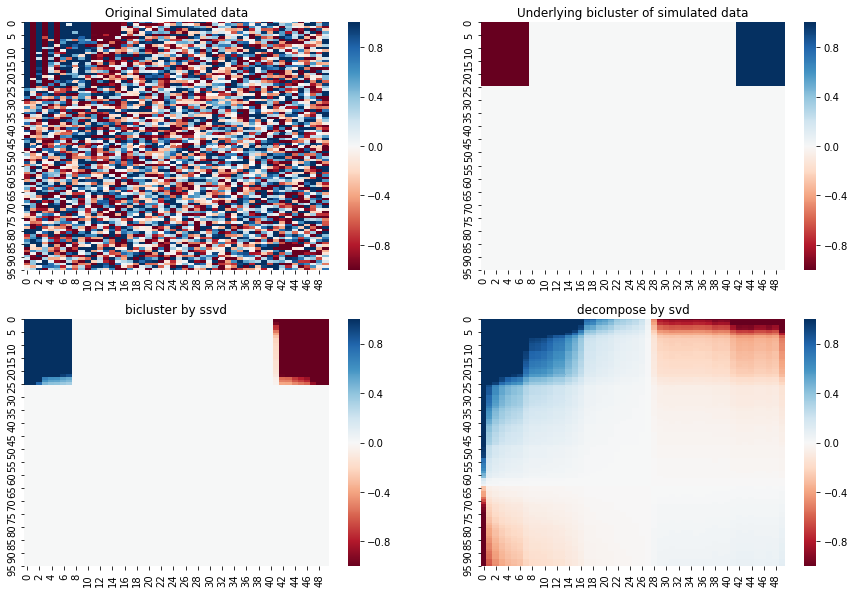

In [13]:
fig, axes = plt.subplots(2,2,figsize=(15,10))
sns.heatmap(X_sim, cmap ="RdBu",vmin = -1,vmax = 1,ax=axes[0,0]).set_title("Original Simulated data")
biclusterplot(u_til,50,v_til.T, ax = axes[0,1],title = "Underlying bicluster of simulated data")
biclusterplot(u1,s1,v1,ax = axes[1,0],title = "bicluster by ssvd")
biclusterplot(u2[:,0],s2,v2[:,0],ax = axes[1,1],title = "decompose by svd")

We have applied ssvd to simulated data. Since we have already known 'truth' underlying singular vector of simulated data, we can measure how well our algorithm detect its underlying structure. First, when we investigated simulated data itself, it looked very noisy because of added simulation noise. However, we could see that actually bicluster under simulated data was nearly identical to estimated bicluster by our algorithm. On contrary, even though svd also classified underlying structure of simulated data, it failed to find checkboard structure precisely as much as ssvd. Therefore, we can conclude that our algorithm works properly and ssvd is more appropriate algorithm to find checkboard structure under the data. 

## Application to real data

#### Lung cancer data from paper

For application to real data, we arranged two real dataset. First dataset is lung cancer data which was also used in Lee's paper and it has a lot of columns and small number of observations(56 $\times$ 12625) as descried before. For this lung cancer data, we expected to 
find underlying biclusters in lung cancer data with first, second, and third layer as Lee did in paper. First layer is the best approximation of data with adaptive lasso penalty as described at method part. Next few layers are estimated based on residuals from previous approximations. In below plots, we can find that founded biclusters are very similar with the results of Lee's paper. The only difference is that we did not divide subject into subgroups whereas they did. Except for this point, it is able to find that our algorithm works well and produce similar results with Lee. From these results, we can find that subject 0 to 21 has positive association with gene 0 to 1684 and negative association with gene 10946 to 12625 whereas subject 24 to 56 have opposite association with similar gene groups. In addition, from gene selection aspects, we can find that 3205, 2511, and 1221 genes are indicated as none-zero entries and other genes indicated as 0 can be considered not important in determining the disease. 

In [14]:
#data import
X = np.loadtxt('data/lung_cancer.txt').T
X.shape

(56, 12625)

In [15]:
u1,s1,v1,iters = ssvd_opt(X)
X_r1 = X-s1*np.outer(u1,v1)
u2,s2,v2,iters = ssvd_opt(X_r1)
X_r2 = X_r1 - s1*np.outer(u2,v2)
u3,s3,v3,iters = ssvd_opt(X_r2)

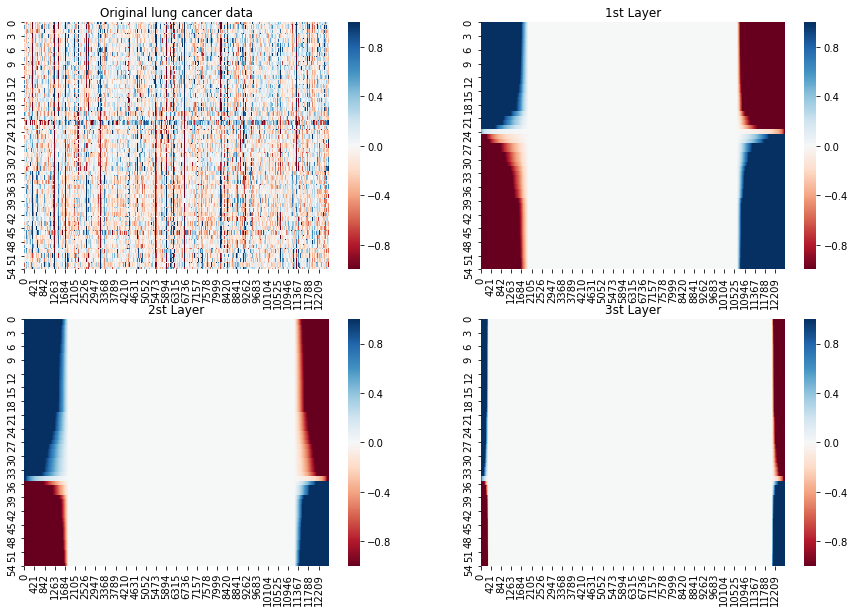

In [16]:
fig, axes = plt.subplots(2,2,figsize=(15,10))
sns.heatmap(X, cmap ="RdBu",vmin = -1,vmax = 1,ax=axes[0,0]).set_title("Original lung cancer data")
biclusterplot(u1,s1,v1,ax = axes[0,1],title = "1st Layer")
biclusterplot(u2,s2,v2,ax = axes[1,0],title = "2st Layer")
biclusterplot(u3,s3,v3,ax = axes[1,1],title = "3st Layer")

#### Breast cancer data from outside

For second real data, breast cancer data is used which is available at "http://genome-www.stanford.edu/aCGH_breast/data/DNA_RNA_data.txt". This data includes some NA observations, so we decided to fill NA with 0 values. Then, as lung cancer data, it is possible to find that X2 is HDLSS data($87 \times 6095$). We have conducted same process with breast cancer data. Contrary to lung cancer data, for breast cancer data, SSVD algorithm fails to converge. This failure is obvious when we investigate plots below. When we see the first layer plot, estimated cluster is less compact than we have seen in the first layer of lung cancer data. Except for the first layer, second and third layers are succeed to converge. When we interpret the estimated clusters in first layer, we can find that from 0 to 24 subjects have positive association with 1 ~ 1400 genes and have negative association with about 5000 ~ 6095. On the other hand, 72 ~ 84 subjects have opposite association that 0 to 24 subjects have. 

In [17]:
X2 = pd.read_table("data/breast_cancer.txt").drop(["CLID","NAME"],axis = 1)
X2 = np.array(X2).T
X2 = np.ma.masked_invalid(X2)
X2 = X2.filled(0)
X2.shape

(87, 6095)

In [18]:
u1,s1,v1,iters = ssvd_opt(X2)
X2_r1 = X2-s1*np.outer(u1,v1)
u2,s2,v2,iters = ssvd_opt(X2_r1)
X2_r2 = X2_r1 - s1*np.outer(u2,v2)
u3,s3,v3,iters = ssvd_opt(X2_r2)

need to increase niter!


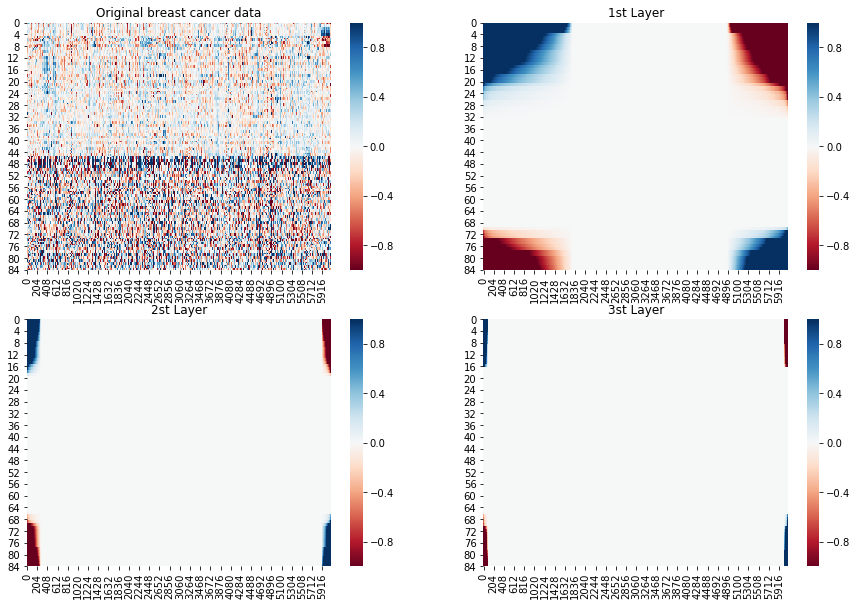

In [19]:
fig, axes = plt.subplots(2,2,figsize=(15,10))
sns.heatmap(X2, cmap ="RdBu",vmin = -1,vmax = 1,ax=axes[0,0]).set_title("Original breast cancer data")
biclusterplot(u1,s1,v1,ax = axes[0,1],title = "1st Layer")
biclusterplot(u2,s2,v2,ax = axes[1,0],title = "2st Layer")
biclusterplot(u3,s3,v3,ax = axes[1,1],title = "3st Layer")

## Comparative analysis with competing algorithms

As Lee et al. has done in their paper, we decided to compare other decompostion method using simulation data $X^* = suv^T$ with noise $\epsilon$. The candidate models are regular SVD, Sparse PCA, and Spectral Biclustering from Klguer et al (2003). Sparse SVD is also finding latent sparse structure of data. Therefore, it is a very similar algorithm with SSVD. However, SSVD and SPCA is definitely different in their purpose. The fundemental purpose of SPCA is reducing dimesion of data whereas the goal of SSVD is decomposing data and find latent association in data. Besides SVD based decomposition, we also compared biclustering method called Spectral Biclustering. The comparsion between these models were conducted based on their accuracy of finding actual latent stucture of data which was measured by the average number of 0 in decomposed vectors and their sensitivity and specificity in finding zero in decomposed vector. In addition to their accuracy, the running time for each algorithm were also examined. The existing function for svd was provided from Numpy.linalg function and for SPCA was provided from sklearn.decomposition package with SparsePCA function. Lastly, spectral biclustering from sklearn.cluster's SpectralBiclustering is also used.

In [20]:
from sklearn import decomposition
from sklearn.cluster import SpectralBiclustering

In [21]:
def classify(est, val):
    num_zero = sum(est == 0)
    corr_zero = sum((est == 0)&(val == 0))/np.sum(val == 0)
    corr_none = sum((est != 0)&(val != 0))/np.sum(val != 0)
    miss_rate = sum(((est == 0)&(val != 0)) | ((est != 0)&(val == 0)))/len(val)
    return np.array([num_zero,corr_zero,corr_none,miss_rate])

In [22]:
def sim_compare(u,v,s,niter = 100):
    X_temp = s*u*v.T
    n,d = X_temp.shape
    u_ssvd = np.zeros((len(u),niter));v_ssvd = np.zeros((len(v),niter));ssvd_time = np.zeros(niter) 
    u_svd = np.zeros((len(u),niter));v_svd = np.zeros((len(v),niter));svd_time = np.zeros(niter) 
    u_pca = np.zeros((len(u),niter));v_pca = np.zeros((len(v),niter));spca_time = np.zeros(niter)
    u_bc = np.zeros((len(u),niter));v_bc = np.zeros((len(v),niter));bc_time = np.zeros(niter)
    for i in range(niter):
        X_sim = X_temp + np.random.randn(n,d)
        ## ssvd
        start = time.time()
        u_ssvd[:,i],s,v_ssvd[:,i],iters = ssvd_opt(X_sim)
        ssvd_time[i] = time.time() - start
         
        ## svd
        start = time.time()
        u1,s1,v1 = np.linalg.svd(X_sim)
        u_svd[:,i],v_svd[:,i]= u1[:,0],v1[0,:]
        svd_time[i] = time.time() - start
        
        ## spca
        start = time.time()
        model = decomposition.SparsePCA(n_components=1,alpha = 3)
        model.fit(X_sim)
        v_pca[:,i] = model.components_[0]
        model.fit(X_sim.T)
        u_pca[i,:] = model.components_[0]
        spca_time[i] = time.time() - start
    
        ## SpectralBiclustering
        start = time.time()
        model = SpectralBiclustering(n_clusters=4,n_components=1,n_best = 1)
        model.fit(X_sim)
        u_bc[:,i] = model.row_labels_
        v_bc[:,i] = model.column_labels_
        bc_time[i] = time.time() - start
        
    time_table = np.c_[ssvd_time,svd_time,spca_time,bc_time]
    time_table = time_table.mean(axis = 0)
    
    comparison_table = np.zeros((8,4))
    row = 0
    for uval in [u_ssvd,u_svd,u_pca,u_bc]:
        comparison_table[2*row,:] = np.array(classify(uval,u)).mean(axis=1)
        row = row+1
    row = 0
    for vval in [v_ssvd,v_svd,v_pca,v_bc]:
        comparison_table[2*row+1,:] = np.array(classify(vval,v)).mean(axis=1)
        row = row+1

    return time_table, comparison_table

In [23]:
time_table, comparison_table = sim_compare(u_til,v_til,s=50)

In [24]:
time_table = pd.DataFrame(np.round(time_table,decimals=3), index = ["SSVD","SVD","SPCA","SBC"], columns=["Avg time by sec"])

In [25]:
comparison_table = pd.DataFrame(np.round(comparison_table,decimals=2),
                                index = ["SSVD-u","SSVD-v","SVD-u","SVD-v","SPCA-u","SPCA-v","SBC-u","SBC-v"],
                                columns=["Avg # of 0", "Sensitivity of 0","Specificity of 0","Miss rate"])

In [26]:
display(comparison_table)

,Avg # of 0,Sensitivity of 0,Specificity of 0,Miss rate
SSVD-u,69.61,0.93,1.00,0.05
SSVD-v,31.13,0.92,1.00,0.06
SVD-u,0.00,0.00,1.00,0.75
SVD-v,0.00,0.00,1.00,0.68
SPCA-u,75.64,0.76,0.24,0.37
SPCA-v,33.88,1.00,1.00,0.00
SBC-u,52.11,0.62,0.77,0.34
SBC-v,24.45,0.60,0.74,0.35


In [27]:
display(time_table)

,Avg time by sec
SSVD,0.044
SVD,0.003
SPCA,0.107
SBC,0.116


When we investigated the result of comparison between candidate models, it is able to find that SSVD overwhelm other decomposition and biclustering method in all aspects of performances. First, SVD absolutely failed to capture underlying zero entries in singluar vectors. As a result, SVD captured all none-zero entries indicated as 100% specificity and 75%, 68% miss classification rate. Despite of poor classification performance, running time of SVD was much shorter than other methods. On the other hand, SPCA succeeded to classify none-zero and zero entries in v vector. However, it showed poor performance in classifying zero and none-zero in u vector which overestimated the number of zero entries in u. Lastly, Spectral Biclustering showed relatively balanced results like SSVD. But the performance in sensitivity and specificity was much lower than SSVD. Moreover, the running time of SPCA and Spectral Biclustering was 2 times longer than SSVD. From this result, we can conclude that SSVD is better method than other methods. 

## Discussion/conclusion

In this paper, we have rewritten Lee et al's R and matlab code into python code and optimized them to shorten their running time. This optimized Sparse Singular Value Decomposition function succeed to find latent association of both simulated data and real world data. As we have shown at comparison part, SSVD shows superiority over other methods in detecting latent sparse checkerboard structure in simulation data. Not only it shows better performance, but also its running time is shorter than other biclustering methods.   
 
This well-performed function is expected to be applied to other gene micro-array data. It is very useful tools which can be used for exploratory analysis because it shows general structure and association under dataset. Lastly, it can be utilized as a way of variable selection by excluding columns which does not show any association with rows.   

The limitation we have found in this function is that it fails to converge occasionally. This situation was occurred when we compare the performance of each models by simulation and application to breast cancer data. This situation might indicate that this algorithm cannot be applied to other sort of data and need further study to solve these situations. 

Finally, there can be a few points to improve from this algorithm. For example, other information criterion can be applied to determine optimal values of adaptive lasso penalty such as Mallows's Cp, AIC, or Deviance Information Criterion(DIC). In addition, the convergence condition needs to be further investigated during the iterative steps in order to show whether this will become a constrain for this algorithm.

## Distribution

This optimized function is available at "https://github.com/jaehyunlee1221/STA-663-Final-Project". In addition, it is possible to install `STA-663-Final-Project-SSVD` pacakge from both Test pypi and pypi.   
You can install this package by commands below 
1. python3 -m pip install -i https://test.pypi.org/simple/ STA-663-Final-Project-SSVD
2. python3 -m pip install STA-663-Final-Project-SSVD

## References/bibliography

[1] Lee, M., Shen, H., Huang, J., and Marron, J. (2010), "Biclustering via Sparse Singular Value Decomposition", Biometrics, 66, 1087–1095.  

[2] Kluger, Y., Basri, R., Chang, JT., Gerstein, M. (2003), "Spectral biclustering of microarray data: coclustering genes and conditions", Genome Res, 13(4), 703-16